In [3]:
import os

import pandas as pd
import numpy as np
import utils.dhs_config as dhs_config
import utils.dhs_utils as dhs

In [4]:
import matplotlib.pyplot as plt

In [5]:
# Main folder with respect from the scripts
MAIN = "../"

# Data folder
DATA = os.path.join(MAIN, "data")

# Raw data folder (where .sav files are)
RAW_DATA = os.path.join(DATA, "raw")

# Transformed data folder
TRS_DATA = os.path.join(DATA, "transformed")

column_variables, column_others = dhs_config.get_columns()

if not(os.path.exists(os.path.join(TRS_DATA, 'df_all.csv'))):
    df_all, couple_all = dhs.get_all_data(RAW_DATA,
                                          column_variables + column_others)
    
    # In year 1994 and 1996 there is some change in the psy question
    # so we skip thoses and also only take the variables of interest
    df_reduce = df_all[~df_all.year.isin([1994, 1996])][column_variables]
    couple_reduce = couple_all[~couple_all.year.isin([1994, 1996])]
    couple_clean = couple_reduce[couple_reduce.married == 1]

    # we clean the data and drop schooling as we did not have the time to clean it
    teg_dict, spaar_dict = dhs_config.get_dict()
    df_clean = df_reduce.replace(teg_dict).replace(spaar_dict).drop('scholing', axis=1)
    
    df_all.to_csv(os.path.join(TRS_DATA, 'df_all.csv'))
    couple_all.to_csv(os.path.join(TRS_DATA, 'couple_all.csv'))
    df_clean.to_csv(os.path.join(TRS_DATA, 'df_clean.csv'))
    couple_clean.to_csv(os.path.join(TRS_DATA, 'couple_clean.csv'))

else:
    df_clean = pd.read_csv(os.path.join(TRS_DATA, 'df_clean.csv'), index_col=0)
    couple_clean = pd.read_csv(os.path.join(TRS_DATA, 'couple_clean.csv'), index_col=0)

In [6]:
df_clean.head()

,gez1,gez3,bmi,spaar1,spaar2,spaar3,spaar4,spaar5,spaar6,teg1,...,teg7,teg8,teg9,teg10,teg11,teg12,teg13,teg14,teg15,teg16
199311360002,193.0,Good,22.282477,5,4,5,7,4,4,5,...,5,5,4,2,5,3,5,5,5,3
199316480001,181.0,Excellent,21.366869,6,4,4,6,2,4,4,...,5,4,6,1,7,1,7,6,6,1
199302570001,184.0,Not so good,33.081285,6,4,4,6,2,2,6,...,4,7,7,1,1,5,3,4,2,5
199302570002,170.0,Excellent,24.221453,6,6,1,7,1,2,4,...,5,5,4,2,4,2,7,6,6,2
199307690001,178.0,Fair,23.355637,3,4,3,4,3,1,6,...,4,4,3,4,6,4,5,6,5,2


In [491]:
from numpy.linalg import svd
from IPython.display import clear_output

In [306]:
def sinkhorn(mu1, mu2, C, epsilon=0.1, max_iters=50):
    """Run Sinnkhorn's algorithm"""
    
    K = np.exp(C/epsilon)
    
    a = np.ones(mu2.shape[0])
    err = 1
    for _ in range(max_iters):
        b = mu1 / K.dot(a)
        a = mu2 / K.T.dot(b)
    
    return a, b

def A_descent(A, t, X, Y, l):
    epsilon = 0.1
    a, b = sinkhorn(mu1, mu2, C, epsilon = 0.1, max_iters=10)
    K = np.exp(-C/0.1)
    pi_A = np.diag(b).dot(K).dot(np.diag(a))
    
    grad = np.diag(pi_A)@((X*Y).sum(axis=1))
    _A = A - t*(np.diag(pi_A)@((X*Y).sum(axis=1)))
    U, S, V = svd(A)
    
    step = (S - t*l)
    step *= (step>0)
    
    print(step)
    diff = np.abs(A - U@np.diag(step)@V).sum()
    
    return U@np.diag(step)@V, diff

In [330]:
def sinkhorn_1(mu1, mu2, C, sigma=0.1, max_iters=100):
    """Run Sinnkhorn's algorithm"""
    
    K = np.exp(C/sigma)
    b = np.ones(mu2.shape[0])
    
    for _ in range(max_iters):
        a = mu1 / K.T.dot(b)
        b = mu2 / K.dot(a)
        
    return a, b

In [331]:
C = X@A@Y.T

a, b = sinkhorn_1(mu1, mu2, C, max_iters=10)
K = np.exp(C/0.1)
pi_A = np.diag(a).dot(K).dot(np.diag(b))

In [332]:
df_num = df_clean.drop(["gez3","teg3"], axis=1)

Full = df_num.to_numpy(dtype=float)
mean, std = Full.mean(axis=0), Full.std(axis=0)

X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

In [333]:
X = X[:50, :10]
Y = Y[:50, :10]

In [334]:
X_population_size, X_feature_size = X.shape
Y_population_size, Y_feature_size = Y.shape

mu1 = np.ones(X_population_size)/X_population_size
mu2 = np.ones(Y_population_size)/Y_population_size

A = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

In [335]:
C = X@A@Y.T

a, b = sinkhorn_1(mu1, mu2, C, max_iters=2000)
K = np.exp(C/0.1)
pi_A = np.diag(a).dot(K).dot(np.diag(b))

In [336]:
pi_A.sum()

1.3334477188716658

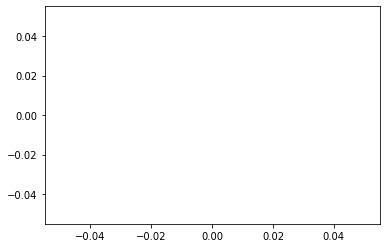

In [298]:
losses = []
losses_coeff = []

sigma = 0.1
t = 0.1
l = 0.1

try:
    while True:
        
        C = X@A@Y
        a, b = sinkhorn_1(mu1, mu2, C, sigma=sigma, max_iters=10)
        K = np.exp(C/sigma)
        pi_A = np.diag(a).dot(K).dot(np.diag(b))
        
        grad = 0
        coeffs = pi_A - np.diag(np.ones(pi_A.shape[0]))/pi_A.shape[0]
        losses_coeff.append(np.abs(coeffs).sum())
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                grad += (coeffs[i, j])*(X[i, :, None]@Y[j, None, :])

            
        A = A - t*(grad)
        losses.append(np.abs(t*(grad)).sum())
        
        clear_output(wait=True)
        
        
        plt.plot(losses_coeff)
        plt.title(losses_coeff[-1])
        plt.show()
        
except:
    plt.plot(losses)
    plt.show()

In [152]:
pi_A = np.diag(b).dot(K).dot(np.diag(a))

In [156]:
pi_A.sum()

0.3490512976008917

### New Try

In [430]:
df_num = df_clean.drop(["gez3","teg3"], axis=1)

Full = df_num.to_numpy(dtype=float)
mean, std = Full.mean(axis=0), Full.std(axis=0)

X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

X = X[:50, :10]
Y = Y[:60, :10]

In [431]:
X_population_size, X_feature_size = X.shape
Y_population_size, Y_feature_size = Y.shape

mu1 = np.ones(X_population_size)/X_population_size
mu2 = np.ones(Y_population_size)/Y_population_size

A = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

$$
\Phi(x, y) = x^TAy
$$

In [432]:
def get_cost(X, Y, A):
    return X@A@Y.T

## Sinkhorn’s algorithm
$$
a\leftarrow \frac{\mu_1}{\int{b(y) e^{\Phi(x, y) / \sigma} dy}}
$$

$$
b\leftarrow \frac{\mu_2}{\int{a(x) e^{\Phi(x, y) / \sigma} dx}}
$$

In [452]:
def Sinkhorn(mu1, mu2, Phi, sigma=0.1, max_iter=100):
    b = np.ones_like(mu2)
    K = np.exp(Phi/sigma)
    for _ in range(max_iter):
        a = mu1/(K.dot(b))
        b = mu2/(K.T.dot(a))
        
    return a, b

## Distribution
$$
\pi^A(x, y) = a(x)b(y)e^{\Phi(x, y)/\sigma}
$$

In [447]:
def get_distr(a, b, Phi):
    return ((np.diag(a).dot(np.exp(Phi/sigma))).dot(np.diag(b)))

In [448]:
Phi = get_cost(X, Y, A)
a, b = Sinkhorn(mu1, mu2, Phi)
pi_A = get_distr(a, b, Phi)

## Proximal Gradient Descent
$$
A\leftarrow A - t\left( \sum_{i, j = 1}^N (\pi_{ij}^A - \hat{\pi}_{ij}) x^i (y^j)^T \right)
$$
$$
[U, S, V] = \text{SVD}(A)
$$
$$
A\leftarrow U \text{ diag}((s_0 - t\lambda)_+, ...(s_d - t\lambda)_+)V^T
$$

In [529]:
def proximal_descent(A, X, Y, t=0.1, l=0.1, sigma=0.1, n_steps=100, verbose=True, svd_flag=False):
    X_size = X.shape[0]
    Y_size = Y.shape[0]
    size = min(X_size, Y_size)
    if verbose:
        history_coeffs = []
        history_grad = []

    for _ in range(n_steps):
        Phi = get_cost(X, Y, A)
        a, b = Sinkhorn(mu1, mu2, Phi, sigma)
        pi_A = get_distr(a, b, Phi)
        pi_hat = np.zeros_like(pi_A)
        np.fill_diagonal(pi_hat, 1/size)
        coeffs = pi_A - pi_hat

        grad = 0
        
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                grad += coeffs[i, j]*(X[i, :, None]@Y[j, None, :])

        A -= t*grad

        if svd_flag and l != 0:
            U, s, V = svd(A)
            _s = s - t*l
            _s *= (s > 0)

            A = U@np.diag(_s)@V

        if verbose:
            clear_output(wait=True)
            history_coeffs.append(np.abs(coeffs).sum())
            history_grad.append(np.abs(grad).sum())

            plt.figure(figsize=(14, 7))
            ax = plt.subplot(121)
            ax.plot(history_coeffs)
            ax.set_title("Distances Between measures")

            ax = plt.subplot(122)
            ax.plot(history_grad)
            ax.set_title("L1 Norm of Gradient")

            plt.show()
    return A, history_coeffs, history_grad

In [530]:
df_num = df_clean.drop(["gez3","teg3"], axis=1)

Full = df_num.to_numpy(dtype=float)
mean, std = Full.mean(axis=0), Full.std(axis=0)

X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

X = X[:50]
Y = Y[:50]

In [531]:
A_all = {}
history_coefs_all = {}
history_grad_all = {} 

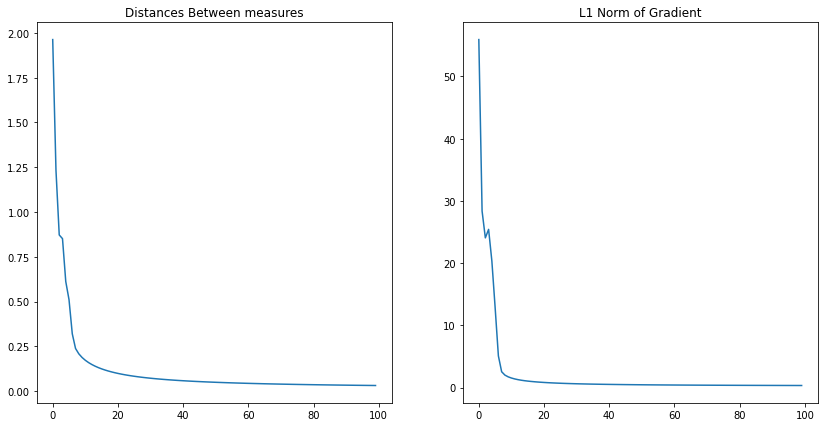

In [532]:
for i in range(23):
    df_num = df_clean.drop(["gez3","teg3"], axis=1)

    Full = df_num.to_numpy(dtype=float)
    mean, std = Full.mean(axis=0), Full.std(axis=0)

    X = (df_num.loc[couple_clean.part1, ].to_numpy(dtype=float) - mean)/std
    Y = (df_num.loc[couple_clean.part2, ].to_numpy(dtype=float) - mean)/std

    X = X[:50, :i]
    Y = Y[:50, :i]
    
    X_population_size, X_feature_size = X.shape
    Y_population_size, Y_feature_size = Y.shape

    mu1 = np.ones(X_population_size)/X_population_size
    mu2 = np.ones(Y_population_size)/Y_population_size

    A = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

    A, history_coefs, history_grad = proximal_descent(A, X, Y)
    A_all[i] = A
    history_coefs_all[i] = history_coefs
    history_grad_all[i] = history_grad

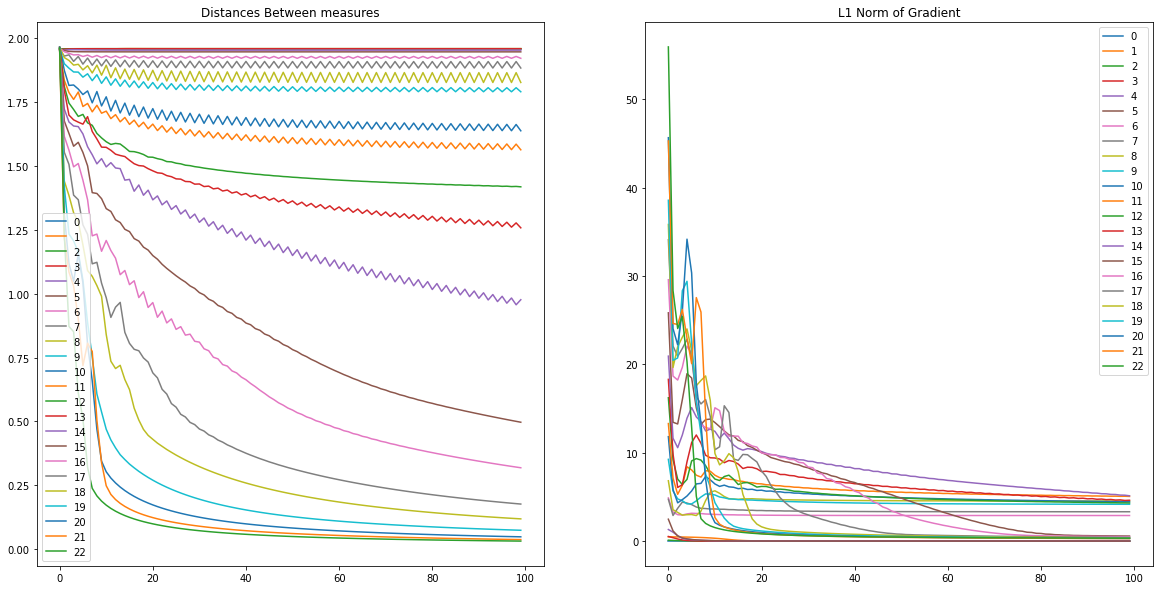

In [537]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
for key, item in history_coefs_all.items():
    ax.plot(item, label=key)
    
ax.set_title("Distances Between measures")

ax.legend()

ax = plt.subplot(122)

for key, item in history_grad_all.items():
    ax.plot(item, label=key)
    
ax.set_title("L1 Norm of Gradient")

ax.legend()
plt.show()